In [1]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract
import zbar
import labelreader
import skimage.morphology

Populating the interactive namespace from numpy and matplotlib


In [7]:
# 64
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/74.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grad = labelreader.imageGrads(gray)
borders, borderCnts = labelreader.imageBordersHough(grad)
objgrad = labelreader.imageObjgrad(grad, borders)
cnts = labelreader.imageContours(objgrad)
boxes = labelreader.imageBoxes(objgrad)
lines = labelreader.imageLinesRecursive(boxes)
lineboxes = labelreader.lineBoxes(lines, boxes)
linetexts = ["" for b in lineboxes]
#linetexts = labelreader.imageTexts(gray, lineboxes, vmargin=2, hmargin=2)
#print [(txt, b)
#        for txt, b in zip(linetexts, lineboxes)
#        if txt]

cxcccc 67 68
cxcccc 59 67
cxcccc 57 59
cxcccc 55 57
cxcccc 53 55
cxcccc 52 53
cxcccc 51 52
cxcccc 50 51
cxcccc 49 50
cxcccc 48 49
cxcccc 47 48
cxcccc 46 47
cxcccc 45 46
cxcccc 44 45
cxcccc 43 44
cxcccc 42 43
cxcccc 41 42
cxcccc 40 41
cxcccc 39 40
cxcccc 38 39
cxcccc 37 38
cxcccc 36 37
cxcccc 35 36
cxcccc 34 35
cxcccc 33 34
cxcccc 32 33
cxcccc 31 32
cxcccc 30 31
cxcccc 29 30
cxcccc 28 29
cxcccc 27 28
cxcccc 26 27
cxcccc 25 26
cxcccc 24 25
cxcccc 23 24
cxcccc 22 23
cxcccc 21 22
cxcccc 20 21
cxcccc 19 20
cxcccc 18 19
cxcccc 17 18
cxcccc 16 17
cxcccc 15 16
cxcccc 14 15
cxcccc 13 14
cxcccc 12 13
cxcccc 11 12
cxcccc 10 11


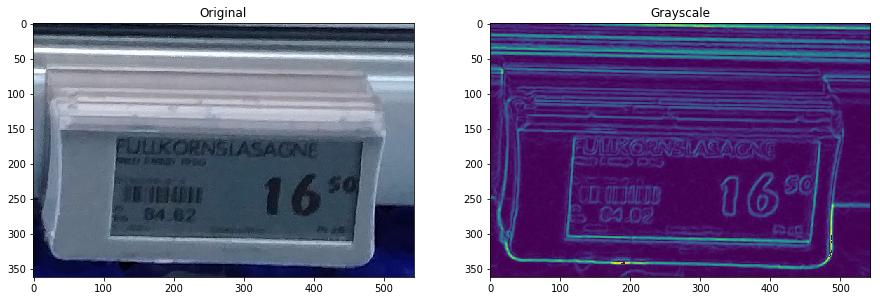

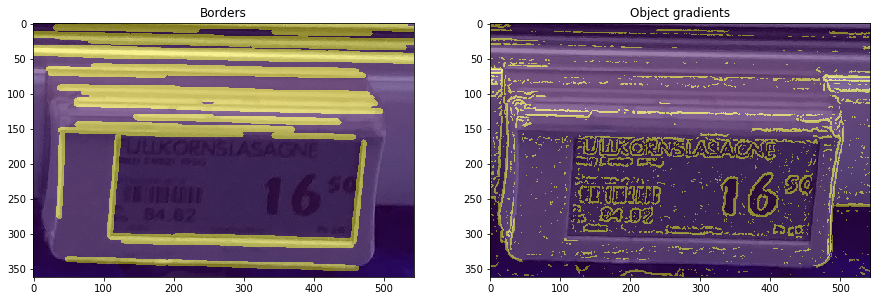

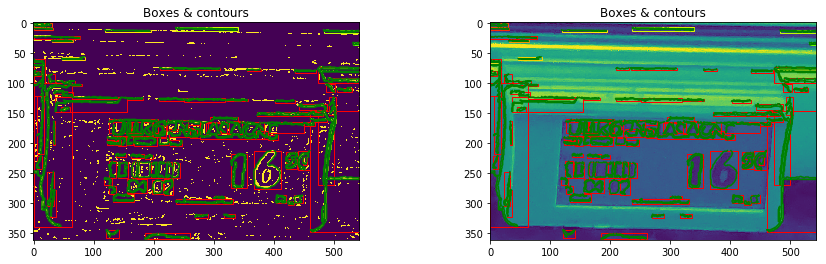

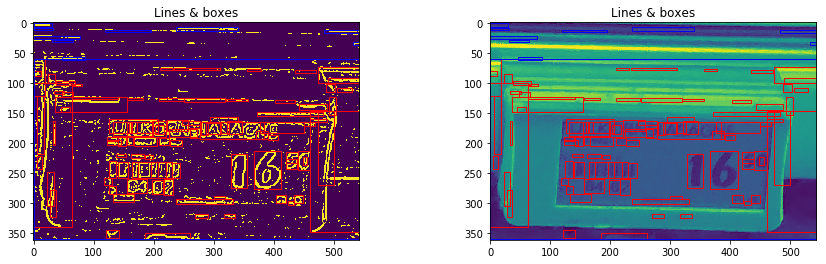

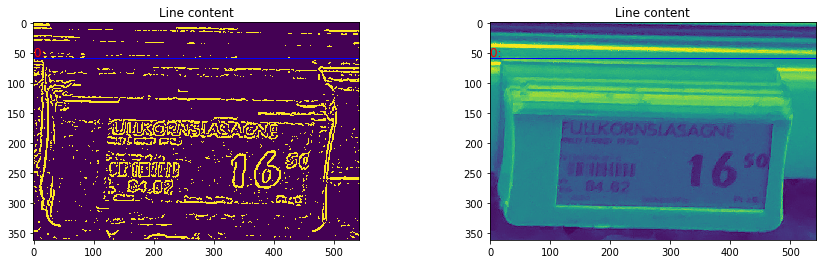

In [8]:
fig = plt.figure(); fig, axs = plt.subplots(1,2, figsize=(15,5)); axs = axs.flatten()
axs[0].imshow(image); axs[0].set_title('Original')
axs[1].imshow(gray); axs[1].set_title('Grayscale')
fig.show()

plt.imshow(grad)
plt.show()

fig = plt.figure(); fig, axs = plt.subplots(1,2, figsize=(15,5)); axs = axs.flatten()
axs[0].imshow(image, alpha=1); axs[0].imshow(borders, alpha=0.5); axs[0].set_title('Borders')
axs[1].imshow(image, alpha=1); axs[1].imshow(objgrad, alpha=0.5); axs[1].set_title('Object gradients')
fig.show()

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Boxes & contours')
axs[1].imshow(gray); axs[1].set_title('Boxes & contours')
for idx in (0, 1):
    labelreader.drawCountours(axs[idx], cnts)
    labelreader.drawLines(axs[idx], lines, boxes)
fig.show()


fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Lines & boxes')
axs[1].imshow(gray); axs[1].set_title('Lines & boxes')
for idx in (0, 1):
    labelreader.drawLineParts(axs[idx], lines, boxes)
    labelreader.drawLineBoxes(axs[idx], lineboxes)
    fig.show()
    
        
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Line content')
axs[1].imshow(gray); axs[1].set_title('Line content')
for idx in (0, 1):
    labelreader.drawLineBoxesAndText(axs[idx], lineboxes, linetexts, vmargin=2, hmargin=2)
    fig.show()

10